#**FINAL PROJECT: DEEP LEARNING ASSESSMENT**

#**RAMSES MORENO DE LA CRUZ - MMU ID: 23624012**

# **1. CONFIGURATION OF THE ENVIRONMENT / LOADING LIBRARIES**

In [ ]:
#PIL
  #Python Library.
  #Used for opening, manipulating, and saving many different image file formats.
  #Used for loading and preprocessing images before converting them into PyTorch tensors.
from PIL import Image

#torch:
  #PyTorch library.
  #It provides multi-dimensional arrays (tensors) and operations on these tensors.
import torch

#torch.nn:
  #PyTorch Module
  #It provides support (classes and functions for defining layers, loss functions, activation functions, etc) for building ANN.
import torch.nn as nn

#torch.utils.data.random_split:
  #PyTorch Module
  #It splits a dataset into random training and validation subsets.
from torch.utils.data import random_split

#torch.utils.data import DataLoader
  #PyTorch Module
  #It provides a "DataLoader class" that wraps a dataset and provides an iterable over the dataset in batches.
  #It handles "data loading, shuffling, batching, etc", making it easier to feed data into ANN for training and evaluation.
#torch.utils.data import Subset
  #PyTorch Module
  #It creates a subset of a larger dataset by specifying indices of the samples that we want to include in the subset.
from torch.utils.data import DataLoader, Subset

#torchvision:
  #PyTorch library.
  #It is designed for computer vision tasks (image, video, pre-trained models, etc).
import torchvision

#torchvision.transforms
  #PyTorch Module
  #transform or augment data for training or inference.
from torchvision.transforms import v2

#torchvision.datasets (not necessary in this case, because I have my own set):
  #PyTorch Module
  #It provides support for popular datasets used in computer vision, such as CIFAR-10, MNIST, and ImageNet.
  #It includes classes for downloading, loading, and preprocessing these datasets.
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

#tqdm
  #Python library
  #It is used to add progress bars to loops or iterators.
  #"tqdm.auto" it is helpful to ensure that the appropriate version of tqdm is used based on the environment (notebook, IDE,...)
from tqdm.auto import tqdm

#Matplotlib library ("pyplot" submodule alias "plt")
import matplotlib.pyplot as plt

#**2. LOADING THE DATASET**

In [ ]:
#!pip install
  #"command" (due to !) used to "install" Python packages (in this case the package is called "opendatasets")
    #"-q" for "quiet" mode for installing the package (it won't display detailed output during installation)
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
od.download('https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset')
#Important; insert kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ramsesmdlc
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset


100%|██████████| 79.4M/79.4M [00:01<00:00, 72.0MB/s]


# **3. CONFIGURATION OF THE DATASET**

##**3.1. DATA TRANSFORMATION**

* Apply transformations techniques to the dataset (training and test set).

In [ ]:
#DATA TRANSFORMATION (original dataset)

#Training Set Transformation
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#Training / Test Set Transformed
train_dataset = datasets.ImageFolder("melanoma-cancer-dataset/train", transform=train_transform)
test_dataset = datasets.ImageFolder("melanoma-cancer-dataset/test", transform=test_transform)


In [ ]:
# Construct datasets.
train_dataset = datasets.ImageFolder("melanoma-cancer-dataset/train", transform=train_transform)
test_dataset = datasets.ImageFolder("melanoma-cancer-dataset/test", transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.6
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 11879 samples
Train set has 7127 samples
Validation set has 4752 samples
Test set has 2000 samples


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

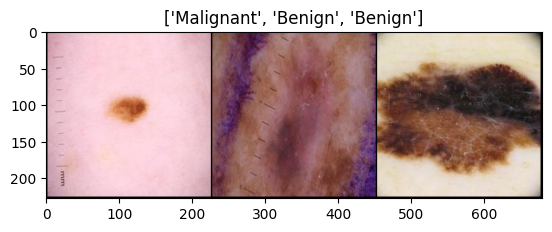

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=3, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Malignant','Benign']

imshow(out, title=[class_names[x] for x in classes])

##**3.2. DATA TRANSFORMATION / DATA AUGMENTATION**

* Apply augmentation techniques to the dataset (training and validation set). The data augmentation is going to be applied in the following order:
  1. Random Crops
  2. Affine
  3. Flips
  4. Saturation, contrast, brightness and hue


In [ ]:
#DATA TRANSFORMATION + DATA AUGMENTATION

#Compose
  #It allows a sequence of transformations operations.

#RandomResizedCrop
  #Crop a random portion of the input and resize it to a given size.
  #Parameters:
    #size: expected output size of the crop, for each edge.
    #In this case is (224,224) because it is the same size of the input images from the dataset.

    #scale (tuple of python: min_scale, max_scale): lower and upper bounds for the random area of the "crop exectution" with respect...
    #...to the area of the original image.
      #This means that the size of the cropped area will be randomly chosen from a range between "min_scale" and "max_scale" of the original image.
      #The scale is typically specified as a fraction or percentage of the original image size.
      #In this case is (0.08, 1.0), the cropping area will cover between 8% and 100% of the original image size

    #ratio (tuple of python: min_ratio, max_ratio): lower and upper bounds for the "aspect ratio" of the cropped area.
      #The "aspect ratio" is calculated as "width divided by height" (w/h).
      #"Ratio range" controls if the cropped area is more square-like or elongated.
      #In this case is (0.75, 1.33), the aspect ratio will range from "w/h = 0.75" (more elongated) to "w/h = 1.333" (more square-like).

#RandomAffine
  #Apply affine transformation on the image keeping image center invariant.
  #Parameters:
    #degrees (sequence or number): range of degrees to select from (-degrees, +degrees = min degrees, max degrees).
    #In this case is 90°

    #shear (sequence or number): range of degrees to select from (between -180 to 180, clockwise )
      #shear angle value in degrees.
      #If shear is a number, a shear parallel to the x-axis in the range (-shear, +shear) will be applied.
      #In this case is 20°

    #scale (tuple): This argument will be used as the scaling factor for both the horizontal and vertical directions (a, b)
      #scaling factor interval from which the algorithm is going to randomly choose (a <= scale <= b)
      #In this case is the scale factor interval (0.8 <= scale <= 1.2), (i.e., scaling the image changes its size but retains its aspect ratio)

#RandomHorizontalFlip
  #Horizontally flip the input.
  #Parameters:
    #p (float): probability of the input being flipped. Default value is 0.5 (50%)

#ColorJitter
  #Randomly change the brightness, contrast, saturation and hue of an image.

#Important definitions:
  #Brightness: it measures the overall lightness or darkness of an image.
  #Contrast: it measures the difference in brightness between the lightest and darkest parts of an image.
    #Increasing contrast makes the bright areas brighter and the dark areas darker.
  #Saturation: it measures the intensity or purity of colors in an image.
    #Increasing saturation makes colors appear more vivid. Decreasing saturation makes colors appear less vivid or grayscale.
  #hue: is the main/basic color that creates the base for whatever we are seeing ("hue colors" are: primary, secondary and tertiary colors).
    #It does not describe shades.
    #Increasing the hue shifts the colors of the image towards warmer tones (red ones)
    #Decreasing the hue shifts the colors of the image towards cooler tones (blue ones)

#-----------------------------------------------------------------------------------------------------------------------
#DATA AUGMENTATION (augmented dataset)

#Training set Augmentation
train_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(size=[224, 224],scale=[0.08, 1.00], ratio=[0.75, 1.33]),
    transforms.RandomAffine(degrees=90, shear=20, scale=(0.80, 1.20)),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.ColorJitter(brightness=(0.70, 1.30), contrast=(0.70, 1.30), saturation=(0.70, 1.30), hue=(-0.10, 0.10)),
    transforms.ToTensor(),
])

#Test Set Augmentation
test_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(size=[224, 224],scale=[0.08, 1.00], ratio=[0.75, 1.33]),
    transforms.RandomAffine(degrees=90, shear=20, scale=(0.80, 1.20)),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.ColorJitter(brightness=(0.70, 1.30), contrast=(0.70, 1.30), saturation=(0.70, 1.30), hue=(-0.10, 0.10)),
    transforms.ToTensor(),
])

In [ ]:
# Construct datasets
train_aug_dataset = datasets.ImageFolder("melanoma-cancer-dataset/train", transform=train_aug_transform)
test_aug_dataset = datasets.ImageFolder("melanoma-cancer-dataset/test", transform=test_aug_transform)

# Define the desired ratio for train and evaluation data (e.g., 60% train, 40% evaluation)
train_ratio_aug = 0.6
val_ratio_aug = 1 - train_ratio_aug

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size_aug = int(train_ratio_aug * len(train_aug_dataset))
val_size_aug = len(train_aug_dataset) - train_size_aug

# Split the train dataset into train and evaluation subsets
train_subset_aug, val_subset_aug = random_split(train_aug_dataset, [train_size_aug, val_size_aug])

print(f'Original train set has {len(train_aug_dataset)} samples')
print(f'Train set has {len(train_subset_aug)} samples')
print(f'Validation set has {len(val_subset_aug)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 11879 samples
Train set has 7127 samples
Validation set has 4752 samples
Test set has 2000 samples


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader_aug = DataLoader(train_subset_aug, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader_aug = DataLoader(val_subset_aug, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader_aug = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

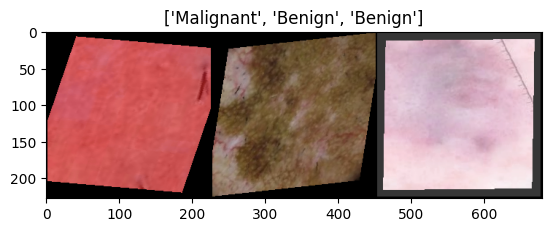

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset_aug, batch_size=3, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Malignant','Benign']

imshow(out, title=[class_names[x] for x in classes])

#**4. MODEL**

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 2)
        )

    def forward(self, x):

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

# **5. LOSS AND OPTIMIZER**

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# **6. TRAIN AND VALIDATION PHASE**

In [ ]:
# The number of training epochs.
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

n_epochs = 25

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)


    # Printing some performance metrics
    print("Training Results:")
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(logits.argmax(dim=-1).cpu().numpy())

    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC ROC: {roc_auc_score(y_true, y_pred):.4f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # Printing some performance metrics
    print("\nValidation Results:")
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in valid_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(logits.argmax(dim=-1).cpu().numpy())

    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC ROC: {roc_auc_score(y_true, y_pred):.4f}")

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[2903  866]
 [ 499 2859]]
Precision: 0.7675
Recall: 0.8514
F1 Score: 0.8073
AUC ROC: 0.8108


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2008  512]
 [ 336 1896]]
Precision: 0.7874
Recall: 0.8495
F1 Score: 0.8172
AUC ROC: 0.8231
[Epoch: 001/025] Train: loss=0.61873, acc=0.69900 | Valid: loss=0.43104, acc=0.82194


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3190  579]
 [ 503 2855]]
Precision: 0.8314
Recall: 0.8502
F1 Score: 0.8407
AUC ROC: 0.8483


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2163  357]
 [ 340 1892]]
Precision: 0.8413
Recall: 0.8477
F1 Score: 0.8445
AUC ROC: 0.8530
[Epoch: 002/025] Train: loss=0.42950, acc=0.80981 | Valid: loss=0.35041, acc=0.85277


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3338  431]
 [ 641 2717]]
Precision: 0.8631
Recall: 0.8091
F1 Score: 0.8352
AUC ROC: 0.8474


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2268  252]
 [ 447 1785]]
Precision: 0.8763
Recall: 0.7997
F1 Score: 0.8363
AUC ROC: 0.8499
[Epoch: 003/025] Train: loss=0.38130, acc=0.83512 | Valid: loss=0.33003, acc=0.85319


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3302  467]
 [ 531 2827]]
Precision: 0.8582
Recall: 0.8419
F1 Score: 0.8500
AUC ROC: 0.8590


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2244  276]
 [ 371 1861]]
Precision: 0.8708
Recall: 0.8338
F1 Score: 0.8519
AUC ROC: 0.8621
[Epoch: 004/025] Train: loss=0.36131, acc=0.84216 | Valid: loss=0.30952, acc=0.86409


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3340  429]
 [ 586 2772]]
Precision: 0.8660
Recall: 0.8255
F1 Score: 0.8453
AUC ROC: 0.8558


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2269  251]
 [ 410 1822]]
Precision: 0.8789
Recall: 0.8163
F1 Score: 0.8465
AUC ROC: 0.8584
[Epoch: 005/025] Train: loss=0.35061, acc=0.84818 | Valid: loss=0.31484, acc=0.86116


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3437  332]
 [ 725 2633]]
Precision: 0.8880
Recall: 0.7841
F1 Score: 0.8328
AUC ROC: 0.8480


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2325  195]
 [ 508 1724]]
Precision: 0.8984
Recall: 0.7724
F1 Score: 0.8306
AUC ROC: 0.8475
[Epoch: 006/025] Train: loss=0.33428, acc=0.85522 | Valid: loss=0.32735, acc=0.85235


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3186  583]
 [ 343 3015]]
Precision: 0.8380
Recall: 0.8979
F1 Score: 0.8669
AUC ROC: 0.8716


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2170  350]
 [ 253 1979]]
Precision: 0.8497
Recall: 0.8866
F1 Score: 0.8678
AUC ROC: 0.8739
[Epoch: 007/025] Train: loss=0.31899, acc=0.86079 | Valid: loss=0.29894, acc=0.87311


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3240  529]
 [ 375 2983]]
Precision: 0.8494
Recall: 0.8883
F1 Score: 0.8684
AUC ROC: 0.8740


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2196  324]
 [ 262 1970]]
Precision: 0.8588
Recall: 0.8826
F1 Score: 0.8705
AUC ROC: 0.8770
[Epoch: 008/025] Train: loss=0.31581, acc=0.86531 | Valid: loss=0.29230, acc=0.87668


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3469  300]
 [ 601 2757]]
Precision: 0.9019
Recall: 0.8210
F1 Score: 0.8595
AUC ROC: 0.8707


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2328  192]
 [ 407 1825]]
Precision: 0.9048
Recall: 0.8177
F1 Score: 0.8590
AUC ROC: 0.8707
[Epoch: 009/025] Train: loss=0.31385, acc=0.86455 | Valid: loss=0.30420, acc=0.87437


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3031  738]
 [ 209 3149]]
Precision: 0.8101
Recall: 0.9378
F1 Score: 0.8693
AUC ROC: 0.8710


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2094  426]
 [ 141 2091]]
Precision: 0.8308
Recall: 0.9368
F1 Score: 0.8806
AUC ROC: 0.8839
[Epoch: 010/025] Train: loss=0.30342, acc=0.86713 | Valid: loss=0.28928, acc=0.88087


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3185  584]
 [ 309 3049]]
Precision: 0.8393
Recall: 0.9080
F1 Score: 0.8723
AUC ROC: 0.8765


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2162  358]
 [ 229 2003]]
Precision: 0.8484
Recall: 0.8974
F1 Score: 0.8722
AUC ROC: 0.8777
[Epoch: 011/025] Train: loss=0.29075, acc=0.87097 | Valid: loss=0.29658, acc=0.87647


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3246  523]
 [ 279 3079]]
Precision: 0.8548
Recall: 0.9169
F1 Score: 0.8848
AUC ROC: 0.8891


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2198  322]
 [ 193 2039]]
Precision: 0.8636
Recall: 0.9135
F1 Score: 0.8879
AUC ROC: 0.8929
[Epoch: 012/025] Train: loss=0.29372, acc=0.87307 | Valid: loss=0.27617, acc=0.89157


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3477  292]
 [ 501 2857]]
Precision: 0.9073
Recall: 0.8508
F1 Score: 0.8781
AUC ROC: 0.8867


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2335  185]
 [ 349 1883]]
Precision: 0.9105
Recall: 0.8436
F1 Score: 0.8758
AUC ROC: 0.8851
[Epoch: 013/025] Train: loss=0.28604, acc=0.87727 | Valid: loss=0.28018, acc=0.88800


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3323  446]
 [ 302 3056]]
Precision: 0.8726
Recall: 0.9101
F1 Score: 0.8910
AUC ROC: 0.8959


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2233  287]
 [ 237 1995]]
Precision: 0.8742
Recall: 0.8938
F1 Score: 0.8839
AUC ROC: 0.8900
[Epoch: 014/025] Train: loss=0.27862, acc=0.87879 | Valid: loss=0.27701, acc=0.88947


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3381  388]
 [ 345 3013]]
Precision: 0.8859
Recall: 0.8973
F1 Score: 0.8916
AUC ROC: 0.8972


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2278  242]
 [ 265 1967]]
Precision: 0.8904
Recall: 0.8813
F1 Score: 0.8858
AUC ROC: 0.8926
[Epoch: 015/025] Train: loss=0.26939, acc=0.87934 | Valid: loss=0.27968, acc=0.89304


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3387  382]
 [ 365 2993]]
Precision: 0.8868
Recall: 0.8913
F1 Score: 0.8891
AUC ROC: 0.8950


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2261  259]
 [ 286 1946]]
Precision: 0.8825
Recall: 0.8719
F1 Score: 0.8772
AUC ROC: 0.8845
[Epoch: 016/025] Train: loss=0.27105, acc=0.88498 | Valid: loss=0.28816, acc=0.88528


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3545  224]
 [ 498 2860]]
Precision: 0.9274
Recall: 0.8517
F1 Score: 0.8879
AUC ROC: 0.8961


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2337  183]
 [ 361 1871]]
Precision: 0.9109
Recall: 0.8383
F1 Score: 0.8731
AUC ROC: 0.8828
[Epoch: 017/025] Train: loss=0.26376, acc=0.88809 | Valid: loss=0.28287, acc=0.88570


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3474  295]
 [ 426 2932]]
Precision: 0.9086
Recall: 0.8731
F1 Score: 0.8905
AUC ROC: 0.8974


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2317  203]
 [ 320 1912]]
Precision: 0.9040
Recall: 0.8566
F1 Score: 0.8797
AUC ROC: 0.8880
[Epoch: 018/025] Train: loss=0.25306, acc=0.89280 | Valid: loss=0.26705, acc=0.89010


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3408  361]
 [ 276 3082]]
Precision: 0.8951
Recall: 0.9178
F1 Score: 0.9063
AUC ROC: 0.9110


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2263  257]
 [ 214 2018]]
Precision: 0.8870
Recall: 0.9041
F1 Score: 0.8955
AUC ROC: 0.9011
[Epoch: 019/025] Train: loss=0.24695, acc=0.89547 | Valid: loss=0.27485, acc=0.90059


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3445  324]
 [ 286 3072]]
Precision: 0.9046
Recall: 0.9148
F1 Score: 0.9097
AUC ROC: 0.9144


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2282  238]
 [ 227 2005]]
Precision: 0.8939
Recall: 0.8983
F1 Score: 0.8961
AUC ROC: 0.9019
[Epoch: 020/025] Train: loss=0.24230, acc=0.89950 | Valid: loss=0.26128, acc=0.90164


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3537  232]
 [ 349 3009]]
Precision: 0.9284
Recall: 0.8961
F1 Score: 0.9120
AUC ROC: 0.9173


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2323  197]
 [ 268 1964]]
Precision: 0.9088
Recall: 0.8799
F1 Score: 0.8941
AUC ROC: 0.9009
[Epoch: 021/025] Train: loss=0.23284, acc=0.90011 | Valid: loss=0.26572, acc=0.90206


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3608  161]
 [ 575 2783]]
Precision: 0.9453
Recall: 0.8288
F1 Score: 0.8832
AUC ROC: 0.8930


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2360  160]
 [ 428 1804]]
Precision: 0.9185
Recall: 0.8082
F1 Score: 0.8599
AUC ROC: 0.8724
[Epoch: 022/025] Train: loss=0.22404, acc=0.90300 | Valid: loss=0.31928, acc=0.87626


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3561  208]
 [ 334 3024]]
Precision: 0.9356
Recall: 0.9005
F1 Score: 0.9178
AUC ROC: 0.9227


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2327  193]
 [ 292 1940]]
Precision: 0.9095
Recall: 0.8692
F1 Score: 0.8889
AUC ROC: 0.8963
[Epoch: 023/025] Train: loss=0.22602, acc=0.90320 | Valid: loss=0.26951, acc=0.89786


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3583  186]
 [ 317 3041]]
Precision: 0.9424
Recall: 0.9056
F1 Score: 0.9236
AUC ROC: 0.9281


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2338  182]
 [ 292 1940]]
Precision: 0.9142
Recall: 0.8692
F1 Score: 0.8911
AUC ROC: 0.8985
[Epoch: 024/025] Train: loss=0.21429, acc=0.90561 | Valid: loss=0.27320, acc=0.90038


  0%|          | 0/223 [00:00<?, ?it/s]

Training Results:
Confusion Matrix:
 [[3548  221]
 [ 229 3129]]
Precision: 0.9340
Recall: 0.9318
F1 Score: 0.9329
AUC ROC: 0.9366


  0%|          | 0/149 [00:00<?, ?it/s]


Validation Results:
Confusion Matrix:
 [[2304  216]
 [ 242 1990]]
Precision: 0.9021
Recall: 0.8916
F1 Score: 0.8968
AUC ROC: 0.9029
[Epoch: 025/025] Train: loss=0.20596, acc=0.91164 | Valid: loss=0.25769, acc=0.90352


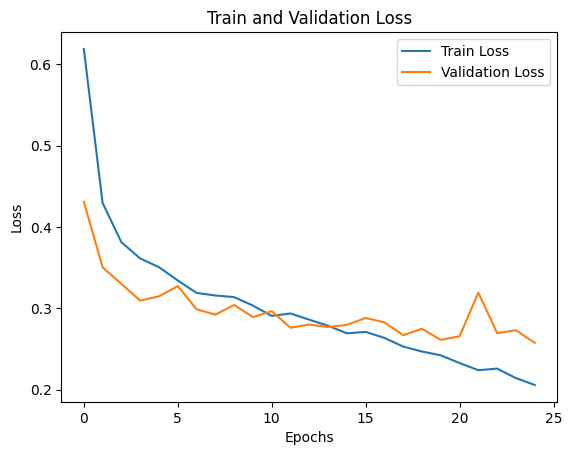

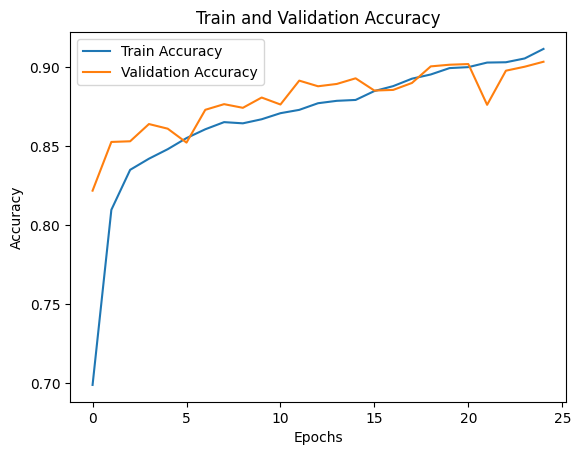

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

#**7. TEST PHASE**

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# Printing some performance metrics
print("\nTest Results:")
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(dim=-1).cpu().numpy())

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print(f"AUC ROC: {roc_auc_score(y_true, y_pred):.4f}")

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/63 [00:00<?, ?it/s]


Test Results:
Confusion Matrix:
 [[943  57]
 [ 96 904]]
Precision: 0.9407
Recall: 0.9040
F1 Score: 0.9220
AUC ROC: 0.9235
Test accuracy 0.922619104385376


#**8. HYPOTHESIS TESTING**

##**8.1. HYPOTHESIS TESTING (TRAINING SET)**

In [ ]:
#TRAINING OUTPUTS
# import pandas as pd
import pandas as pd

# import numpy as np
import numpy as np

# simple array
data_without_dropout_tr = np.array([0.9869])
data_with_dropout_tr = np.array([0.9836, 0.9475, 0.9777, 0.9611, 0.9329])

group11_tr = pd.Series(data_without_dropout_tr)
group22_tr = pd.Series(data_with_dropout_tr)

In [ ]:
#Test for the median of two independent samples less than 10 instances (Mann-Whitney U test (also known as the Wilcoxon rank-sum test).)

from scipy.stats import mannwhitneyu
U1, p1 = mannwhitneyu(group11_tr, group22_tr, method="exact",alternative='two-sided')

# Check the p-value
print("\np-value, T-test for the median of two independent samples:", p1)

if p1 < 0.05:
    print("\nmedian values are significantly different (p_value < 0.05); therefore, the Null Hypothesis can be rejected.\n")
else:
    print("median values are not significantly different (p_value > 0.05); therefore, we fail to reject the Null Hypothesis.\n")
    print("Consequently, the evidence provided by the data is strongly enough to statistically conclude that\n" +
    "the dropout regularization applied has not impacted the F1-score of the vanilla convolutional neural network a significant way\n")


p-value, T-test for the median of two independent samples: 0.3333333333333333
median values are not significantly different (p_value > 0.05); therefore, we fail to reject the Null Hypothesis.

Consequently, the evidence provided by the data is strongly enough to statistically conclude that
the dropout regularization applied has not impacted the F1-score of the vanilla convolutional neural network a significant way



##**8.2. HYPOTHESIS TESTING (VALIDATION SET)**

In [ ]:
#VALIDATION OUTPUTS
# import pandas as pd
import pandas as pd

# import numpy as np
import numpy as np

# simple array
data_without_dropout_val = np.array([0.8869])
data_with_dropout_val = np.array([0.8774, 0.8609, 0.8908, 0.8949, 0.8968])

group11_val = pd.Series(data_without_dropout_val)
group22_val = pd.Series(data_with_dropout_val)

In [ ]:
#Test for the median of two independent samples less than 10 instances (Mann-Whitney U test (also known as the Wilcoxon rank-sum test).)

from scipy.stats import mannwhitneyu
U2, p2 = mannwhitneyu(group11_val, group22_val, method="exact",alternative='two-sided')

# Check the p-value
print("\np-value, T-test for the median of two independent samples:", p2)

if p2 < 0.05:
    print("\nmedianvalues are significantly different (p_value < 0.05); therefore, the Null Hypothesis can be rejected.\n")
else:
    print("median values are not significantly different (p_value > 0.05); therefore, we fail to reject the Null Hypothesis.\n")
    print("Consequently, the evidence provided by the data is strongly enough to statistically conclude that\n" +
    "the dropout regularization applied has not impacted the F1-score of the vanilla convolutional neural network a significant manner.\n")


p-value, T-test for the median of two independent samples: 1.0
median values are not significantly different (p_value > 0.05); therefore, we fail to reject the Null Hypothesis.

Consequently, the evidence provided by the data is strongly enough to statistically conclude that
the dropout regularization applied has not impacted the F1-score of the vanilla convolutional neural network a significant manner.



##**8.3. HYPOTHESIS TESTING (TEST SET)**

In [ ]:
#TEST OUTPUTS
# import pandas as pd
import pandas as pd

# import numpy as np
import numpy as np

# simple array
data_without_dropout_test = np.array([0.9245])
data_with_dropout_test = np.array([0.9032, 0.9226, 0.9114, 0.9297, 0.922])

group11_test = pd.Series(data_without_dropout_test)
group22_test = pd.Series(data_with_dropout_test)

In [ ]:
#Test for the medians of two independent samples less than 10 instances (Mann-Whitney U test (also known as the Wilcoxon rank-sum test).)

from scipy.stats import mannwhitneyu
U3, p3 = mannwhitneyu(group11_test, group22_test, method="exact",alternative='two-sided')

# Check the p-value
print("\np-value, T-test for the medians of two independent samples:", p3)

if p3 < 0.05:
    print("\nmedian values are significantly different (p_value < 0.05); therefore, the Null Hypothesis can be rejected.\n")
else:
    print("median values are not significantly different (p_value > 0.05); therefore, we fail to reject the Null Hypothesis.\n")
    print("Consequently, the evidence provided by the data is strongly enough to statistically conclude that\n" +
    "the dropout regularization applied has not impacted the F1-score of the vanilla convolutional neural network a significant manner.\n")


p-value, T-test for the medians of two independent samples: 0.6666666666666666
median values are not significantly different (p_value > 0.05); therefore, we fail to reject the Null Hypothesis.

Consequently, the evidence provided by the data is strongly enough to statistically conclude that
the dropout regularization applied has not impacted the F1-score of the vanilla convolutional neural network a significant manner.

